In [1]:
# 필요 모델 호출
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
import time
import random

In [2]:
def seed_everything(seed: int = 2022):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
class config:
    seed = 2022

In [4]:
seed_everything(config.seed)

In [5]:
# 이미지 로드
imglist = os.listdir('/Users/User/303/CDAE_chest128px/train/')
def load_image(path):
    image_list = np.zeros((len(imglist), 128, 128))
    for i in range(len(imglist)):
        img = Image.open('/Users/User/303/CDAE_chest128px/train/'+str(imglist[i])).convert('L')
        image_list[i] = img
    return image_list

In [6]:
posi = load_image('/Users/User/303/CDAE_chest128px/train/*.jpg')
posi = posi.astype('float32')/255.
print(posi.shape)

(6334, 128, 128)


In [7]:
def train_test_split(img):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(img))
    train_idx = perm[:int(0.8 * len(img))]
    test_idx = perm[int(0.8 * len(img)):]
    return img[train_idx], img[test_idx]

x_train, x_test = train_test_split(posi)
print(x_train.shape, x_test.shape)

(5067, 128, 128) (1267, 128, 128)


In [8]:
def noisy(noise_typ,image):
    #Gaussian Noisy
    if noise_typ == "gauss":
        
        noisy = image + 0.1 *  np.random.normal(loc=0,scale=1.,size=image.shape)
        return noisy
    #Salt & Pepper Noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.05
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[tuple(coords)] = 1
        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[tuple(coords)] = 0
        return out

    # Speckle Noisy
    elif noise_typ =="speckle":
        noisy = np.random.normal(loc=0,scale=1.,size=image.shape)
        noisy = image+ image * 0.1 *noisy
        return noisy


In [9]:
def MAE(img1, img2):
    D = np.array(img1 - img2, dtype=np.float64)
    D[:, :] = np.abs(D[:, :])
    MAE = D.sum()/img1.size
    return MAE

def PSNR(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [10]:
from skimage.restoration import denoise_nl_means
from scipy.signal import medfilt2d
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def Meanfilter(noisy_test_data):
    meanfilter = []
    for i in range(len(noisy_test_data)):
         meanfilter.append(cv2.blur(noisy_test_data[i],(3,3)))
    meanfilter = np.array(meanfilter)
    return meanfilter
    
def Medianfilter(noisy_test_data):
    medianfilter = []
    for i in range(len(noisy_test_data)):
        medianfilter.append(medfilt2d(noisy_test_data[i],(3,3)))
    medianfilter = np.array(medianfilter)
    return medianfilter


def lee_filter(img):
    lee = []
    for i in range(len(img)):
        img_mean = uniform_filter(img[i])
        img_sqr_mean = uniform_filter(img[i]**2)
        img_variance = img_sqr_mean - img_mean**2
        
        overall_variance = variance(img[i])
        
        img_weights = (img_variance**2) / ((img_variance**2) + (overall_variance**2))
        img_output = img_mean + img_weights * (img[i] - img_mean)
        
        lee.append(img_output)
    lee = np.array(lee)
    return lee

In [11]:
# Add Noisy
x_train_sp_noisy = noisy("speckle",x_train)
x_test_sp_noisy = noisy("speckle",x_test)

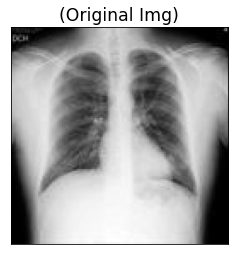

In [12]:
# Original Image
ax = plt.subplot()
plt.imshow(x_test[1200], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Original Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

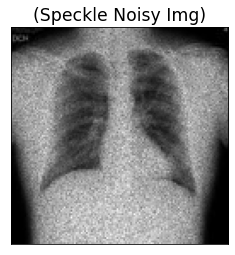

In [13]:
# Salt & Pepper Noisy Image
ax = plt.subplot()
plt.imshow(x_test_sp_noisy[1200], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Speckle Noisy Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

CPU 시간 : 0.10935831069946289


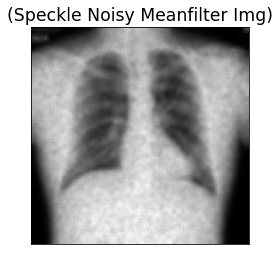

In [14]:
# MeanFilter Image
start = time.time()
mean_x_test_sp_noisy = Meanfilter(x_test_sp_noisy)
end = time.time()
Meantime= end - start
print("CPU 시간 : "+str(Meantime))

ax = plt.subplot()
plt.imshow(mean_x_test_sp_noisy[1200], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Speckle Noisy Meanfilter Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

CPU 시간 : 1.546511173248291


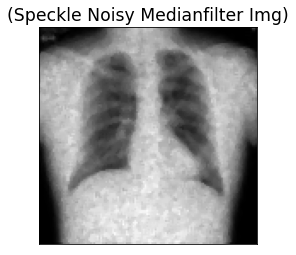

In [15]:
# MedianFilter Image
start = time.time()
median_x_test_sp_noisy = Medianfilter(x_test_sp_noisy)
end = time.time()
Mediantime= end - start
print("CPU 시간 : "+str(Mediantime))

ax = plt.subplot()
plt.imshow(median_x_test_sp_noisy[1200], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Speckle Noisy Medianfilter Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

CPU 시간 : 0.484264612197876


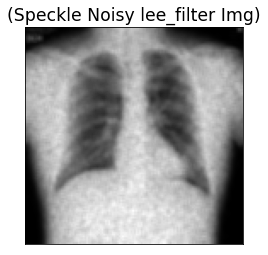

In [16]:
# LeeFilter Image
start = time.time()
lee_x_test_sp_noisy = lee_filter(x_test_sp_noisy)
end = time.time()
Leetime= end - start
print("CPU 시간 : "+str(Leetime))

ax = plt.subplot()
plt.imshow(lee_x_test_sp_noisy[1200], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Speckle Noisy lee_filter Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

In [17]:
#Convolution Neural Networks Filter Image
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, UpSampling2D
# Convolution Auto Encoder Filter Image
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import optimizers
from keras.models import Model

In [18]:
# Convolution Auto Encoder Filter Image
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D ,LeakyReLU,ReLU,Concatenate
from keras import optimizers
from keras.models import Model

In [19]:
epochs = 100
inChannel = 1
x, y = 128, 128
input_img = Input(shape=(x,y,inChannel))

In [20]:
act=LeakyReLU(alpha=0.01)
#act=ReLU()

In [21]:
# Encoder

conv1 = Conv2D(16, (3,3), activation=act, padding='same',name='encoder1_cov')(input_img) 
pool1 = MaxPooling2D(pool_size=(2,2),name='maxpool1')(conv1) 
conv2 = Conv2D(32, (3,3), activation=act, padding='same',name='encoder2_cov')(pool1)
pool2 = MaxPooling2D(pool_size=(2,2),name='maxpool2')(conv2) 
encoded = Conv2D(64, (3,3), activation=act, padding='same',name='encoder3_cov')(pool2) 

# Decoder1
conv4 = Conv2D(64, (3,3), activation=act, padding='same',name='decoder1_cov')(encoded)
up1 = UpSampling2D((2,2),name='up1')(conv4)
conv5 = Conv2D(32, (3,3), activation=act, padding='same',name='decoder2_cov')(up1)
up2 = UpSampling2D((2,2),name='up2')(conv5)

# Decoder2
conv6 = Conv2D(64, (3,3), activation=act, padding='same',name='decoder3_cov')(encoded)
up3 = UpSampling2D((2,2),name='up3')(conv6)
conv7 = Conv2D(32, (3,3), activation=act, padding='same',name='decoder4_cov')(up3)
up4 = UpSampling2D((2,2),name='up4')(conv7)
#Merge
con=Concatenate()([up2,up4])
conv8 = Conv2D(64, (3,3), activation=act, padding='same',name='decoder5_cov')(con)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same',name='result_cov')(conv8)

In [23]:
# CAEFilter Image
autoencoder_sp = Model(input_img, decoded)
autoencoder_sp.compile(loss='mean_squared_error',optimizer=optimizers.Adam())
autoencoder_sp.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder1_cov (Conv2D)          (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 maxpool1 (MaxPooling2D)        (None, 64, 64, 16)   0           ['encoder1_cov[0][0]']           
                                                                                              

In [24]:
x_train_cae = x_train.reshape(5067, 128, 128, 1)
x_test_cae = x_test.reshape(1267, 128, 128,1)
x_train_cae_sp_noisy = x_train_sp_noisy.reshape(5067, 128, 128, 1)
x_test_cae_sp_noisy = x_test_sp_noisy.reshape(1267, 128, 128,1)

In [25]:
autoencodersp_train = autoencoder_sp.fit(x_train_cae_sp_noisy, x_train_cae, 
                                    batch_size=9, 
                                    epochs=epochs, 
                                    verbose=2,
                                    validation_data=(x_test_cae_sp_noisy, x_test_cae))

Epoch 1/100
563/563 - 7s - loss: 0.0026 - val_loss: 7.9011e-04 - 7s/epoch - 13ms/step
Epoch 2/100
563/563 - 5s - loss: 6.7664e-04 - val_loss: 5.7915e-04 - 5s/epoch - 8ms/step
Epoch 3/100
563/563 - 5s - loss: 5.8689e-04 - val_loss: 5.6954e-04 - 5s/epoch - 8ms/step
Epoch 4/100
563/563 - 5s - loss: 5.3730e-04 - val_loss: 5.1086e-04 - 5s/epoch - 8ms/step
Epoch 5/100
563/563 - 5s - loss: 5.1157e-04 - val_loss: 4.5722e-04 - 5s/epoch - 8ms/step
Epoch 6/100
563/563 - 5s - loss: 5.1931e-04 - val_loss: 4.4487e-04 - 5s/epoch - 8ms/step
Epoch 7/100
563/563 - 5s - loss: 4.4517e-04 - val_loss: 4.9574e-04 - 5s/epoch - 8ms/step
Epoch 8/100
563/563 - 5s - loss: 4.3502e-04 - val_loss: 4.2045e-04 - 5s/epoch - 8ms/step
Epoch 9/100
563/563 - 5s - loss: 4.2764e-04 - val_loss: 3.9969e-04 - 5s/epoch - 8ms/step
Epoch 10/100
563/563 - 5s - loss: 4.2024e-04 - val_loss: 4.2221e-04 - 5s/epoch - 8ms/step
Epoch 11/100
563/563 - 5s - loss: 4.1858e-04 - val_loss: 3.8010e-04 - 5s/epoch - 8ms/step
Epoch 12/100
563/563 -

Epoch 93/100
563/563 - 5s - loss: 2.9266e-04 - val_loss: 2.9080e-04 - 5s/epoch - 9ms/step
Epoch 94/100
563/563 - 5s - loss: 2.8923e-04 - val_loss: 2.9118e-04 - 5s/epoch - 9ms/step
Epoch 95/100
563/563 - 5s - loss: 2.9062e-04 - val_loss: 2.9266e-04 - 5s/epoch - 9ms/step
Epoch 96/100
563/563 - 5s - loss: 2.9732e-04 - val_loss: 3.0730e-04 - 5s/epoch - 9ms/step
Epoch 97/100
563/563 - 5s - loss: 2.8850e-04 - val_loss: 2.8600e-04 - 5s/epoch - 9ms/step
Epoch 98/100
563/563 - 5s - loss: 2.8990e-04 - val_loss: 2.8786e-04 - 5s/epoch - 9ms/step
Epoch 99/100
563/563 - 5s - loss: 2.9091e-04 - val_loss: 2.9309e-04 - 5s/epoch - 9ms/step
Epoch 100/100
563/563 - 5s - loss: 2.8886e-04 - val_loss: 3.0965e-04 - 5s/epoch - 9ms/step


In [26]:
start = time.time()
cae_x_test_sp_noisy = autoencoder_sp.predict(x_test_cae_sp_noisy)
print(cae_x_test_sp_noisy.shape)
end = time.time()
Caetime= end - start
print("CPU 시간 : "+str(Caetime))
cae_x_test_sp_noisy = cae_x_test_sp_noisy.reshape(1267, 128, 128)

40/40 [==============================] - 1s 12ms/step
(1267, 128, 128, 1)
CPU 시간 : 0.8591570854187012


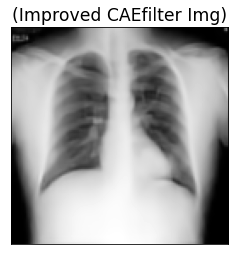

In [27]:
ax = plt.subplot()
plt.imshow(cae_x_test_sp_noisy[1200], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Improved CAEfilter Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

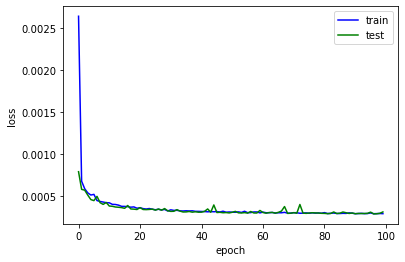

In [28]:
cae_loss = autoencodersp_train.history['loss']
cae_val_loss = autoencodersp_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, cae_loss, 'b', label="train")
plt.plot(epochs, cae_val_loss, 'g', label="test")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [29]:
from skimage.metrics import structural_similarity as ssim


In [34]:
psnr_mean = []
mae_mean = []
psnr_median = []
mae_median = []
mae_lee = []
psnr_lee = []
psnr_cae = []
mae_cae = []

ssim_mean=[]
ssim_median=[]
ssim_lee=[]
ssim_cae=[]

for i in range(len(x_test_sp_noisy)):
    mae_mean.append(MAE(mean_x_test_sp_noisy[i],x_test[i]))
    mae_median.append(MAE(median_x_test_sp_noisy[i],x_test[i]))
    mae_lee.append(MAE(lee_x_test_sp_noisy[i],x_test[i]))
    mae_cae.append(MAE(cae_x_test_sp_noisy[i],x_test[i]))
    #print(cae_x_test_sp_noisy[i].shape)
    #print(x_test[i].shape)
    psnr_mean.append(PSNR(mean_x_test_sp_noisy[i],x_test[i]))
    psnr_median.append(PSNR(median_x_test_sp_noisy[i],x_test[i]))
    psnr_lee.append(PSNR(lee_x_test_sp_noisy[i],x_test[i]))
    psnr_cae.append(PSNR(cae_x_test_sp_noisy[i],x_test[i]))
    ssim_mean.append(ssim(x_test[i], mean_x_test_sp_noisy[i]))#,data_range=mean_x_test_sp_noisy[i].max() - mean_x_test_sp_noisy[i].min()))
    ssim_median.append(ssim(x_test[i], median_x_test_sp_noisy[i]))#,data_range=median_x_test_sp_noisy[i].max() - median_x_test_sp_noisy[i].min()))
    ssim_lee.append(ssim(x_test[i], lee_x_test_sp_noisy[i]))#,data_range=lee_x_test_sp_noisy[i].max() - lee_x_test_sp_noisy[i].min()))
    
    
    ssim_cae.append(ssim(x_test[i], cae_x_test_sp_noisy[i]))#,data_range=cae_x_test_sp_noisy[i].max() - cae_x_test_sp_noisy[i].min()))

C:\Users\User\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [35]:
print("About Gauss Noisy")
print("Mean Filter : MAE = " +  str(np.mean(mae_mean)) + " & PSNR = " + str(np.mean(psnr_mean))+" & SSIM = "+str(np.mean(ssim_mean)))
print("Median Filter : MAE = " +  str(np.mean(mae_median)) + " & PSNR = " + str(np.mean(psnr_median))+" & SSIM = "+str(np.mean(ssim_median)))
print("LEE Filter : MAE = " +  str(np.mean(mae_lee)) + " & PSNR = " + str(np.mean(psnr_lee))+" & SSIM = "+str(np.mean(ssim_lee)))
print("CAE Filter : MAE = " +  str(np.mean(mae_cae)) + " & PSNR = " + str(np.mean(psnr_cae))+" & SSIM = "+str(np.mean(ssim_cae)))


About Gauss Noisy
Mean Filter : MAE = 0.018883786117327706 & PSNR = 31.59165872259118 & SSIM = 0.9259075949122091
Median Filter : MAE = 0.02104792646350124 & PSNR = 30.615579188724844 & SSIM = 0.9019237195237476
LEE Filter : MAE = 0.01811735799438978 & PSNR = 32.41154754215783 & SSIM = 0.9272036287064076
CAE Filter : MAE = 0.012790682764662767 & PSNR = 35.4473026669363 & SSIM = 0.969407562444272


In [33]:
# a=ssim(x_test[1], x_test[1],data_range=1.0)#,data_range=x_test[1].max() - x_test[1].min())
# print(a)